In [1]:
%matplotlib inline

# Assignment 3

**DUE: Sunday November 6, 2022 11:59pm**

Turn in the assignment via Canvas.

To write legible answers you will need to be familiar with both [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) and [Latex](https://www.latex-tutorial.com/tutorials/amsmath/)

Before you turn this problem in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Runtime→→Restart runtime) and then run all cells (in the menubar, select Runtime→→Run All).

Make sure you fill in any place that says "YOUR CODE HERE" or "YOUR ANSWER HERE", as well as your name below:

In [2]:
NAME = "Fabrice Kurmann"
STUDENT_ID = "1808546"

## Question 1 - Logistic Regression
---
In this question, you will build a system for predicting patient deaths in the Intensive Care Unit (ICU) using the large [PhysioNet Computing in Cardiology Challenge 2012 dataset](https://physionet.org/content/challenge-2012/1.0.0/). For each patient in the dataset, demographic variables and time series of physiological variables were collected during their stay in the ICU. 

The risk prediction system you will build could in principle be used to flag patients as being at risk of death so that physicians could intervene and improve their outcome. To be confident about the impact of such a system, you would need to run an experiment. In this question, you will use a model in order to estimate the potential impact of the system.

The data you will be working with is all available from [PhysioNet](https://physionet.org/challenge/2012/). You will be looking at only the data in "Training set A". The patient data files are [https://archive.physionet.org/challenge/2012/set-a.zip](here), and the outcomes file is [https://archive.physionet.org/challenge/2012/Outcomes-a.txt](here).





#### Downloading and Reading in the Data

First, we download the physiological data and read in patient outcomes file (links above).

We want this data to be read from text files and assembled into a dataframe. To do so, please run the following code which will first define a function that reads a text file, and then runs that function on all the files and assembles the outputs into a single dataframe.

#### Downloading the data

In [3]:
!wget https://archive.physionet.org/challenge/2012/set-a.zip -O ./set-a.zip
import zipfile
with zipfile.ZipFile('./set-a.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

--2022-11-05 14:22:37--  https://archive.physionet.org/challenge/2012/set-a.zip
Resolving archive.physionet.org (archive.physionet.org)... 128.30.30.88
Connecting to archive.physionet.org (archive.physionet.org)|128.30.30.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7938449 (7.6M) [application/zip]
Saving to: ‘./set-a.zip’

./set-a.zip         100%[===================>]   7.57M  11.3MB/s    in 0.7s    

2022-11-05 14:22:39 (11.3 MB/s) - ‘./set-a.zip’ saved [7938449/7938449]



#### Reading in data

In [4]:
import pandas as pd
import numpy as np
import glob

def comp_patient(patdat, attrs):
    patdat[patdat == -1.0] = float('NaN')
    patdat_dict = {}
    for attr in attrs:
        patdat_dict[attr] = [patdat["Value"][patdat["Parameter"]==attr].mean(axis = 0)]
    return patdat_dict


attrs = ["Age", "Gender", "Height", "Weight", "Urine", 
         "HR", "Temp", "NIDiasABP", "SysABP", "DiasABP", "pH",
         "PaCO2", "PaO2", "Platelets", "MAP", "K", "Na", "FiO2", "GCS", "RecordID"]


full_dat  = pd.DataFrame(columns = attrs)

# Now let's take the list "all_pat_dat" and assemble it into a dataframe.
filenames = sorted(glob.glob("/content/set-a/*.txt"))
for filename in filenames:
    data = open(filename)
    patient_dat_full = pd.read_csv(data, delimiter=',')
    patient_dat = pd.DataFrame.from_dict(comp_patient(patient_dat_full, attrs))
    full_dat = full_dat.append(patient_dat)

outcome_dat = pd.read_csv("https://archive.physionet.org/challenge/2012/Outcomes-a.txt")
outcome_dat[outcome_dat == -1] = float('NaN') # set all -1 to NaNs
full_dat_out = full_dat.merge(outcome_dat, left_on='RecordID', right_on='RecordID')
full_dat_out.replace([np.inf, -np.inf], np.nan)

col_means = full_dat_out.mean()
# Set everything that's NaN to the mean of that column:

# Note: we do this for simplicity. Strictly speaking, you should
# only use the training set to compute the column means

for i in range(full_dat_out.shape[1]):
    mask = np.isnan(np.array(full_dat_out.iloc[:,i]))
    full_dat_out.iloc[mask, i] = col_means[i]

### a) Understanding the Data (2 points)
Looking at the files and the code provided above, explain:


*   What is the size of your input data? how many parameters exist in the data?
*   Exaplain what the code provided above is trying to achieve.



**A** The input data contains 4000 entries with 6 general descriptors each as well as any number of the 37 variables that may have also been measured during a patient's first two days at the hospital. It appears that this code above is only reading in 20 of the attributes. In a separate data file, the outcomes are stored, this data contains 6 parameters (one of which is a repeat of the RecordID.

**B:** First, a dataframe with columns relating to the attributes given in the attrs list is created. Then, the corresponding data from each of the files is read into the dataframe, called full_dat. During this process, the helper function comp_patient is called to turn any values of -1 into NaN values and then a mean value for that column is computed and also added to the respective column.

The outcome data is then also read in, with -1 and infinity values replaced by NaN. The outcome_dat array is merged with itself to create the full_dat)out array containing all outcomes. Finally, the NaN data points in the full_dat_out array are replaced with the mean value of the output data.

### b) Run Logistic Regression (9 points)


Divide your data into training, validation, and test sets (60-20-20). 

Use the features `HR`, `Gender`, `age`, `temperature`, `weight`, `height`, `PaO2`, and  `PaCO2`, and fit a logistic regression model to predict in-hospital death. 

In [5]:
# print('full_dat')
# print(full_dat.describe())

# print('full_dat_out')
# print(full_dat_out.info())

# # Split data in X and y using pandas functionality.
X = full_dat_out.filter(['HR', 'Gender', 'Age', 'Temp', 'Weight', 'Height', 'PaO2', 'PaCO2']) # Create vector of explanatory variables
y = full_dat_out.filter(['In-hospital_death']) # Create vector of target variables
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


print('Before outlier removal')
print(X.describe())

# Perform z score outlier removal for 
from pandas.core import indexes

def standardize_col(col):
    return (col - col.mean()) / col.std()

# Drop columns for which the height, weight, HR, PaO2, PaCO2 values are outliers
X['HeightZ'] = standardize_col(X['Height'])
drop_indexes = X[abs(X['HeightZ']) > 4].index
X.drop(drop_indexes, inplace = True)
y.drop(drop_indexes, inplace = True)
X.drop(columns='HeightZ', inplace = True)

X['WeightZ'] = standardize_col(X['Weight'])
drop_indexes = X[abs(X['WeightZ']) > 4].index
X.drop(drop_indexes, inplace = True)
y.drop(drop_indexes, inplace = True)
X.drop(columns='WeightZ', inplace = True)

X['HRZ'] = standardize_col(X['HR'])
drop_indexes = X[abs(X['HRZ']) > 4].index
X.drop(drop_indexes, inplace = True)
y.drop(drop_indexes, inplace = True)
X.drop(columns='HRZ', inplace = True)

X['Pa02Z'] = standardize_col(X['PaO2'])
drop_indexes = X[abs(X['Pa02Z']) > 4].index
X.drop(drop_indexes, inplace = True)
y.drop(drop_indexes, inplace = True)
X.drop(columns='Pa02Z', inplace = True)

X['PaC02Z'] = standardize_col(X['PaCO2'])
drop_indexes = X[abs(X['PaC02Z']) > 4].index
X.drop(drop_indexes, inplace = True)
y.drop(drop_indexes, inplace = True)
X.drop(columns='PaC02Z', inplace = True)

print('After outlier removal')
print(X.describe())



Shape of X: (4000, 8)
Shape of y: (4000, 1)
Before outlier removal
                HR       Gender          Age         Temp       Weight  \
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000   
mean     87.159565     0.561921    64.247500    36.956125    83.043044   
std      14.488338     0.496027    17.560946     0.727350    23.118025   
min      42.784314     0.000000    15.000000    21.644615     3.500000   
25%      77.274047     0.000000    52.750000    36.614286    68.201596   
50%      86.617585     1.000000    67.000000    36.963636    82.000000   
75%      96.465443     1.000000    78.000000    37.364603    93.058712   
max     137.842105     1.000000    90.000000    39.748980   300.000000   

            Height         PaO2        PaCO2  
count  4000.000000  4000.000000  4000.000000  
mean    169.787227   147.987136    40.382018  
std      14.637111    49.251648     6.754749  
min       1.800000    26.000000    16.000000  
25%     169.787227   116.775000

In [6]:
# Vectorize X and y
X = X.values
y = y.values
y = y.astype(int) 

# Reshape y
print(y)
y = y.ravel()
print(y)

[[0]
 [0]
 [0]
 ...
 [0]
 [1]
 [0]]
[0 0 0 ... 0 1 0]


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sklearn
from sklearn import datasets, linear_model
from mlxtend.plotting import plot_decision_regions

# Building a step function classifier with threshold = 0
class classifier:
  def predict(self, y):
    return y >= 0

# Function to perform linear regression classification
def perform_logistic_regression(x, y):
    # Splitting the data and label into training and test sets with 80%-20% ratio
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=140)

    # Splitting the training data and label into training and validation sets with 75%-25% ratio
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=140)

    # Training a logistic regression model on the training data
    clf = LogisticRegression().fit(x_train, y_train)

    
    # Checking the accuracy of the model on both training and test data
    print('Training Score: ', clf.score(x_train, y_train))
    print('Testing Score: ', clf.score(x_test, y_test))
    
    # Getting model's parameters and building the theta vector
    theta = np.concatenate([np.expand_dims(clf.intercept_, 1), clf.coef_], 1)
    print("Theta: ", theta)

    # Augmenting the training data with a column of 1's
    x_val_aug = np.hstack([np.ones_like(x_val[:, 0:1]), x_val])

    # Calculating activation values for the training and test data
    z_val = np.matmul(theta, np.transpose(x_val_aug))

    return [clf ,x_train, x_val, x_test, y_train, y_val, y_test, z_val]


classifier_return = perform_logistic_regression(X, y)

Training Score:  0.8636557307200682
Testing Score:  0.8569604086845466
Theta:  [[-0.00181318  0.02426509  0.01153758  0.02621244 -0.11468112 -0.00318883
   0.00964433 -0.00682583 -0.04808744]]


### c) ROC Curve (10 points)

Write a function that, for a given threshold (prob. threshold), calculates both the False Positive Rate (proportion of non-deaths identified as deaths by the model) and True Positive Rate (proportion of deaths correctly identified as such by the model) for your regression model. 

For 100 threshold values equally spaced from 0 to 1, plot the True Positive Rate vs. the False Positive Rate. Use the validation set.

This plot is known as an ROC curve. 


[0.09086054 0.08987609 0.06090505 0.05226788 0.18948866 0.18024256
 0.11946008 0.36711421 0.08657265 0.04773145 0.03276696 0.09720569
 0.06860311 0.09635605 0.35941712 0.03922908 0.09295411 0.10458641
 0.32805649 0.14455925 0.08867242 0.08241199 0.10415248 0.09073488
 0.06612038 0.04183735 0.26983013 0.20316501 0.16355912 0.07801282
 0.13481515 0.06443209 0.08575278 0.22040019 0.05364532 0.09437226
 0.30119786 0.13500364 0.29272237 0.17005725 0.03847641 0.1221044
 0.06509578 0.15490551 0.07544872 0.10055003 0.20611744 0.04920225
 0.07915377 0.09054967 0.34113515 0.06918497 0.19640581 0.57339985
 0.19759695 0.11933449 0.13607098 0.10566492 0.16779333 0.06421164
 0.03109625 0.02225105 0.21121518 0.26737267 0.12995406 0.20987447
 0.07890128 0.14251305 0.21529516 0.20060963 0.07761871 0.05921573
 0.10779596 0.21560979 0.11115885 0.10732353 0.15218451 0.15730801
 0.23570988 0.05938516 0.11156169 0.0648206  0.10270409 0.10197878
 0.24069612 0.06075913 0.31135851 0.04310487 0.45615209 0.21696

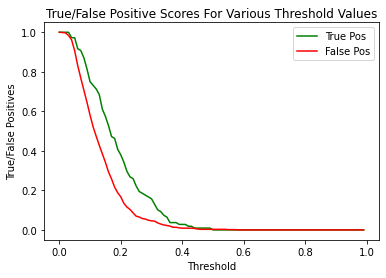

In [8]:
# Return an array containing the probabilities for positive results from the classifier
def get_probs(clf, x):
    num_items = x.shape[0]
    return np.array([clf.predict_proba(x)[i, 1] for i in range(num_items)])

# Return an array containing the value for true and false positives
def false_true_positves(predictions, actual, threshold):
    positives, negatives, true_positives, false_positves = 0, 0, 0, 0

    for j in range(len(predictions)):
        # Count total positives
        if (actual[j] == 1):  positives += 1
        if (actual[j] == 0):  negatives += 1
        # If X is classified as positive and Y is indeed positive
        if ((predictions[j] > (threshold / 100)) and ((actual[j]) == 1)):  true_positives+=1
        # If X is classified as positive and Y is negtive
        if ((predictions[j] > (threshold / 100)) and ((actual[j]) == 0)):  false_positves+=1

    return [(true_positives / positives), (false_positves / negatives), threshold / 100]

# Plot the true.false positive curve
def plot_results(array_t, array_f, thresholds):
    plt.plot(thresholds, array_t, '-g', label='True Pos')
    plt.plot(thresholds, array_f, '-r', label='False Pos')
    plt.title('True/False Positive Scores For Various Threshold Values')
    plt.ylabel('True/False Positives')
    plt.xlabel('Threshold')
    plt.legend(loc="upper right")
    plt.show()

# Make an array of the predictions the trained model gives
probabilities = get_probs(classifier_return[0], classifier_return[2]) 

# Store true and false positives here
true_positive_count, false_positive_count, thresholds = [], [], []

# print(len(probabilities))
# print(len(classifier_return[5]))
print(probabilities)
print(classifier_return[5])

# Iterate through threshold values
for i in range (0, 100):
    results = false_true_positves(probabilities, classifier_return[5], i)
    true_positive_count.append(results[0])
    false_positive_count.append(results[1])
    thresholds.append(results[2])

# Plot
plot_results(true_positive_count, false_positive_count, thresholds)


### d) Interpreting the ROC Curve (4 points)

Using the plot generated in Part (c), what is the False Positive Rate associated with correctly identifying 80% of patients at risk for death in the ICU? Why might a high false positive rate be appropriate in this setting? You can read the answer off the ROC curve plot.


Based on the graph, the false positve rate associated with a true positive rate of 80% is about 63%.

A higher false positive rate in this setting makes sense because this model is predicting whether a newly addmitted patient to the hospital will die there. Getting a positive prediction from this model would cause doctors to be especially careful with these patients to perhaps prevent their death. Being careful with a few extra false positive patients is a small cost for saving a potentally larger amount of true positive patients. Furthermore, false positive results don't trail true positive results by that much, meaning that if a high false positive is not taken into account, the model is not very applicable.


### e) Modelling Doctors' Decision-Making (6 points)

For this part, produce a short report that answers all the questions below. Include code that produces the numbers that you need.

At the beginning of their shift, a doctor reviews their patients' charts, and decides what intervention is needed for each patient. In the following parts, we will be trying to improve this process. We will consider a simplified version of what is going on. Suppose that if the doctor intervenes correctly, the patient will not die; suppose that the doctor has 60 minutes to look through 25 patient charts; and suppose that the probability of missing the correct treatment if the doctor spends $t$ minutes on reviewing a file is

$$P(\textrm{fail}) = \exp(-t^2/100).$$


1. If the doctor reviews all the files, spends an equal amount of time on each chart, and there are 10 patients who will die without the correct intervention, how many patients are expected to die, if the doctor intervenes when they see that that's needed? What is the percentage of patients who are expected to die, out of 25?

2. Suppose now that the doctor is looking through all the patient charts in the validation set. They would have proportionately more time: $(N/25)\times 60$ minutes in total (where $N$ is the total number of patients in the set). How many patients would be expected to die, if the doctor intervenes correctly when they know they should do that?

3. Now, suppose that the doctor only reviews the files of patients for whom the model outputs a probability of greater than $20\%$. This would give the doctor more time to look through each file, but the doctor would never be able to intervene in the cases of patients form whom the output is $20\%$ or smaller. How many patients would be expected to die?



In [9]:
import math
# Classifier output: [clf ,x_train, x_val, x_test, y_train, y_val, y_test, z_val]

# Code for question 2:
y_val = classifier_return[5]
deaths = 0
for patient in y_val:
    if patient == 1: deaths+=1

print('Deaths that occur with no intervention:')
print(deaths)

print('Deaths that occur with doctor intervention (2.4 minute read time):')
print(deaths*0.944)

# Code for question 3:
x_val = probabilities
twentyPercent, twentyPercentDeaths, nonTwentyPercentDeaths = 0, 0, 0
for i in range(len(x_val)):
    if x_val[i] > 0.2: 
        twentyPercent+=1
        if y_val[i] == 1: 
            twentyPercentDeaths+=1
nonTwentyPercentDeaths = deaths - twentyPercentDeaths

timePerPatient = 1879.2 / twentyPercent
lossProbability = math.exp((timePerPatient*timePerPatient)/(-100)) # e^(-t^2/100)

# Calculate the increased saves in the expected to die group
thresholdDeathsAfter = twentyPercentDeaths * lossProbability
# Calculated the increased deaths in the not expected to die group
totalDeathsAfter = thresholdDeathsAfter + nonTwentyPercentDeaths

print('Patients with over 0.2 probability of dying:')
print(twentyPercent)
print('Patients with over 0.2 probability who end up dying and patients with under a 0.2 probability who end up dying:')
print(twentyPercentDeaths, nonTwentyPercentDeaths)

print('Time to allocate to patients with this strategy')
print(timePerPatient)
print('Death probability with this amount of time to read file')
print(lossProbability)
print('Net amount of saved patients')
print(deaths - totalDeathsAfter)

Deaths that occur with no intervention:
108
Deaths that occur with doctor intervention (2.4 minute read time):
101.952
Patients with over 0.2 probability of dying:
154
Patients with over 0.2 probability who end up dying and patients with under a 0.2 probability who end up dying:
41 67
Time to allocate to patients with this strategy
12.202597402597403
Death probability with this amount of time to read file
0.22559050822845655
Net amount of saved patients
31.750789162633282


1) If the doctor spends an equal amount of time on 25 patients, that's 2.4 minutes/patient. That results in a 0.944 probability of failing to treat the patient.

If 10 patients are orgiginally expected to die and the doctor has a 0.944 probability of losing a patient with 2.4 minutes per file, this rounds down to 9 of 10 patients dying and one surviving. 9/25 is 36%. Without rounding down, this 0.944 probability results in 0.944 out of 25 patiens dying, a percentage of 37.8.

2) The validation set is 20% of 4000 patients (783 after outlier removal). If the doctor's changes of failing to save a patient that would otherwise die is still 0.944, then, given that 108 patents in this group would die without the correct intervention, that number * 0.944 = 101.95. This means the doctor saves ~6 patients. 

3) If the doctor reviews only patients who's output probability is greater than 0.2, this is a small subset of the original group. In the case of this data set, that's 154 patients. Given 60 minuets for 25 patients orginally, but now a stack of papers to read through that's only 19.7% of the original, that's 12.2 minutes per paper, resulting in a lower failure to treat probability of 0.23.

Ultimatly, this would save 31.75 patients who would otherwise die.

However, the cost of not reviewing patients with a low probability of death guarantees that the patients in that subgroup who would end up dying really do so, with zero change of being saved. Ultimatly though, this is a very small cost compared to the above benefit.

NOTE: these values can change as different test/validation splits are made.

### f) Modelling Doctors' Decision-Making - Revisited (7 points)


In this Part, you will explore the policy implications of using our model in an understaffed hospital. 

Suppose that we are considering a policy of only reviewing the files of patients whose probability of death is above a threshold `thr`. Each chart would be given an equal amount of time, and the total amount of time will be $(N/25)\times 60$.

Using the model from previous part, plot the total number of expected deaths under the policy vs. the threshold. Using the plot, what is the best threshold to use that would minimize the number of deaths?

You should compute the expected number of deaths for the thresholds `np.arange(0, 1, 0.01)`.

Use the validation set.




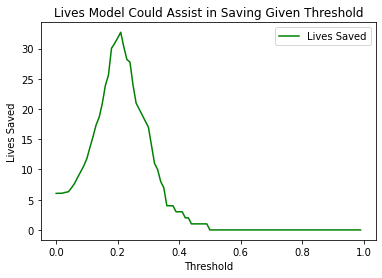

Most lives saved with a threshold: lives saved in validation:
0.21 32.71325845799632


In [10]:
# Find expected and actual death data for a given threshold
def find_expected_deaths(probabilities, actual, threshold):
    thresholdMembers, deaths, thresholdDeaths, subThresholdDeaths = 0, 0, 0, 0
    for i in range(len(probabilities)):
        if actual[i] == 1: deaths+=1
        if probabilities[i] > threshold: 
            thresholdMembers+=1
            if actual[i] == 1: 
                thresholdDeaths+=1
    subThresholdDeaths = deaths - thresholdDeaths

    # Calculate the time to spend with each patient given the size of the expected to die group
    # With entire validation set, doctor has N/25*60 minutes each, this amounts to 1879.2 minutes.
    # If else to prevent div by zero
    if (thresholdMembers == 0): timePerPatient = 1879.2
    else: timePerPatient = 1879.2 / thresholdMembers
    # Find the probability of losing a patient given this amount of file read time
    lossProbability = math.exp((timePerPatient*timePerPatient)/(-100))# e^(-t^2/100)

    # Calculate the increased saves in the expected to die group
    thresholdDeathsAfter = thresholdDeaths * lossProbability
    # Calculated the increased deaths in the not expected to die group
    totalDeathsAfter = thresholdDeathsAfter + subThresholdDeaths
    
    # Determinte the net gain in surviving patients, plot this
    livesSaved = thresholdDeaths + subThresholdDeaths - totalDeathsAfter

    # LivesSaved compares deaths with this threshold to deaths if NOTHING is done
    return [threshold, livesSaved, subThresholdDeaths] 

livesSaved, thresholds = [], []
optimizedThreshold, maxLivesSaved = 0, 0
for i in range (0, 100):
    results = find_expected_deaths(probabilities, y_val, i / 100)
    thresholds.append(results[0])
    livesSaved.append(results[1])

    # To track the maximum
    if results[1] > maxLivesSaved: 
        optimizedThreshold = results[0]
        maxLivesSaved = results[1]

# Show plots, the maximum point, where gain in survivors is highest is the ideal threshold
def plot_results(saved, thresholds):
    plt.plot(thresholds, saved, '-g', label='Lives Saved')
    plt.title('Lives Model Could Assist in Saving Given Threshold')
    plt.ylabel('Lives Saved')
    plt.xlabel('Threshold')
    plt.legend(loc="upper right")
    plt.show()

# Plot
plot_results(livesSaved, thresholds)

print('Most lives saved with a threshold: lives saved in validation:')
print(optimizedThreshold, maxLivesSaved)



The above graph contains a global maximum in terms of lives saved of 32.71 at a threshold value of 0.21. This means, 0.21 is the ideal probability to begin reviewing files for patients, correctly balancing the doctor's limited time to review files with their increased rate of saving a patient after reading their file.

### g) Modelling Doctors' Decision-Making - Testing (7 points)

On the test set, compare the total number of expected deaths under the best policy that was selected in Part (f) to reviewing each patient's file. In relative terms (i.e., as a percentage), how many lives would be saved, if the assumptions underlying our simulation are accurate?

In [11]:
# Classifier output: [clf ,x_train, x_val, x_test, y_train, y_val, y_test, z_val]
testProbabilities = get_probs(classifier_return[0], classifier_return[3]) 

# Get number of deaths with naive file reading approach for test set
y_test = classifier_return[6]
deaths = 0
for patient in y_val:
    if patient == 1: deaths+=1

print('Deaths that occur with no intervention:')
print(deaths)
print('Deaths that occur with naive doctor intervention (2.4 minute read time):')
print(deaths*0.944)
print('Percentage of lives in test set saved with doctor intervention (2.4 minute read time):')
print((1 - (deaths*0.944) / deaths) * 100)

testResults = find_expected_deaths(testProbabilities, classifier_return[6], optimizedThreshold)

print('Sub threshold deaths (these will all occur if threshold method is used):')
print(testResults[2])
print('Sub threshold deaths with naive method:')
print(testResults[2] * 0.944)
print('Difference in sub threshold deaths:')
print(testResults[2] - (testResults[2] * 0.944))

print('Deaths that occur with threshold method:')
print(deaths - testResults[1])
print('Test set size:')
print(len(testProbabilities))
print('Percentage of lives in test set saved:')
print((testResults[1] / len(testProbabilities)) * 100)
print('Percentage of lives in test set saved over naive method:')
print(((testResults[1] - 6.048) / len(testProbabilities)) * 100)







Deaths that occur with no intervention:
108
Deaths that occur with naive doctor intervention (2.4 minute read time):
101.952
Percentage of lives in test set saved with doctor intervention (2.4 minute read time):
5.600000000000005
Sub threshold deaths (these will all occur if threshold method is used):
71
Sub threshold deaths with naive method:
67.024
Difference in sub threshold deaths:
3.975999999999999
Deaths that occur with threshold method:
72.73667512914916
Test set size:
783
Percentage of lives in test set saved:
4.5036174803130065
Percentage of lives in test set saved over naive method:
3.7312036872095575


Using the optimized threshold value, 35.26 lives would be saved in the group who gets reviewed, compared to 2.07 for the naive approach, at a cost of 3.98 lives in the sub-threshold group.

The net gain is 35.26-3.98-2.07 = 29.21 lives. This is 483% of the lives saved by the naive review file method or 3.73% of the total test set or 27.05% of the original 108 deaths.

## Question 2 - Neural Networks
---

We will train a fully connected neural networks to recognize face images of cats and dogs. 

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [13]:
data_dir = 'pets'
image_width = 32
image_height = 32
batch_size = 10

### a) Load the Pets Dataset (2 points)
There are 110 images of size $32\times32$. Run the following code block to import the data. Keep in mind that they will be downloaded from the internet, so it may take a while.

In [14]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [15]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [16]:
# Download the data
downloaded = drive.CreateFile({'id':"1NXiYkupBcolg90e6wE_Nm_F9VTFoXIja"})
downloaded.GetContentFile('pets.npy')  
data = np.load("pets.npy",allow_pickle=True)

In [17]:
# Create X and y
X, y = (data[()]['X'], data[()]['y'])
print(X)
print(y)

[[[ 45  59  38 ...  80  68  65]
  [ 23  39  42 ...  78  82  73]
  [ 17  24  37 ...  84  81  57]
  ...
  [ 64  62  62 ...  50  59  62]
  [ 61  61  60 ...  52  54  57]
  [ 59  60  61 ...  54  52  57]]

 [[ 99 109 119 ... 124 114 105]
  [104 113 130 ... 110 102 112]
  [101 115 127 ... 102 102  94]
  ...
  [198 187 184 ...  96  90 100]
  [204 196 185 ... 109 110 111]
  [211 205 195 ... 124 114 118]]

 [[160 161 173 ... 121 123 102]
  [152 146 148 ... 116 102  84]
  [157 142 130 ...  75  70  71]
  ...
  [222 230 211 ...  54  47  60]
  [231 208 223 ...  71  54  44]
  [214 200 235 ...  47  73  61]]

 ...

 [[ 85 104 124 ... 105 103  85]
  [ 83 103 125 ... 105 104  86]
  [ 82 105 126 ...  75 112  88]
  ...
  [ 89 109 134 ...  37  38  37]
  [ 90 110 134 ...  36  44  34]
  [ 90 116 137 ...  26  29  27]]

 [[105 104 106 ... 169 172 175]
  [ 95  93  98 ... 176 175 174]
  [ 98 100 114 ... 160 166 171]
  ...
  [132 145 140 ... 142 112 116]
  [148 153 153 ... 124 105 106]
  [130 128 133 ... 137 115 1

In [18]:
# Get class names and create ID
class_names = ['cat', 'dog']
class_dict = {i:class_name for i,class_name in enumerate(class_names)}

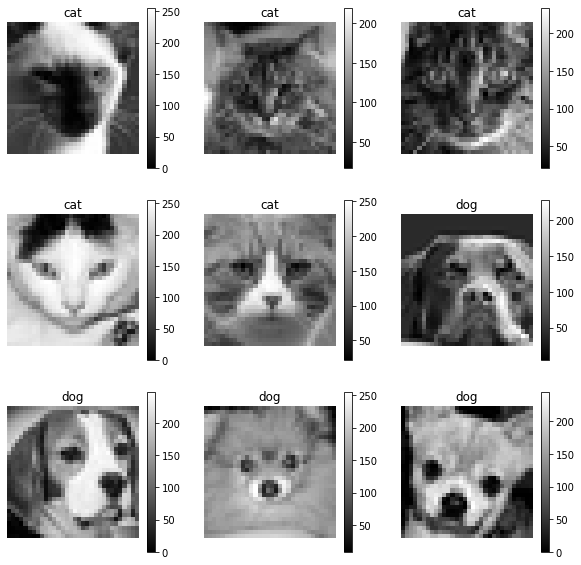

In [19]:
# Plot some images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for count, i in enumerate(range(0,110, 13)):
    ax = plt.subplot(3, 3, count + 1)
    plt.imshow(X[i],cmap='gray')
    plt.colorbar()
    plt.title(class_names[y[i]])
    plt.axis("off")

Answer the following questions:

1.) What are the data types for X and y?

2.) What are the shapes of X and y?

3.) What is the minimum and maximum value of X?

X and y are both arrays of length 110, where X is an array of 2D arrays of dimension 32 by 32 containing values ranging from 0 to 255 and y is a 1D array of binary values, the image classifications.

X contains 110 2d arrays mapping pixels of the images. Each entry in X(i) corresponds to one pixel in the image, the larger the numerical value of the cell, the lighter the image is in that spot.

The minimum value of X is an array containing all zeros, this would correspond to a completely black image, the maximum value would be all 255s, corresponding to a completely white image.

### b) Data Preprocessing (3 points)
As you can see above, the pixel values are in the [0,255]. This is the normal range for images. Recall from the previous lectures and excercises that we need to normalize our data.

In order to normalize our data to [0,1] we use the equation:

$$x_{norm}=\frac{x-x_{min}}{x_{max}-x_{min}}$$

In our case we can assume that $x_{min}=0$ and $x_{max}=255$, this is a safe assumption since we are working with image data.

This means that for image data, if we want to normlize to [0,1] the equation simplifies to:

$$img_{norm}=\frac{img}{255}$$

Anytime you work with image data in any kind of model you will be normalizing with this equation. Unless the range you want to normalize is different. Sometimes you want to normalize between [-1,1], for that you would use a slightly different equation.

Normalize the X data using the above equation and save as train_images.

In [20]:
train_images = X/255
print(train_images)

[[[0.17647059 0.23137255 0.14901961 ... 0.31372549 0.26666667 0.25490196]
  [0.09019608 0.15294118 0.16470588 ... 0.30588235 0.32156863 0.28627451]
  [0.06666667 0.09411765 0.14509804 ... 0.32941176 0.31764706 0.22352941]
  ...
  [0.25098039 0.24313725 0.24313725 ... 0.19607843 0.23137255 0.24313725]
  [0.23921569 0.23921569 0.23529412 ... 0.20392157 0.21176471 0.22352941]
  [0.23137255 0.23529412 0.23921569 ... 0.21176471 0.20392157 0.22352941]]

 [[0.38823529 0.42745098 0.46666667 ... 0.48627451 0.44705882 0.41176471]
  [0.40784314 0.44313725 0.50980392 ... 0.43137255 0.4        0.43921569]
  [0.39607843 0.45098039 0.49803922 ... 0.4        0.4        0.36862745]
  ...
  [0.77647059 0.73333333 0.72156863 ... 0.37647059 0.35294118 0.39215686]
  [0.8        0.76862745 0.7254902  ... 0.42745098 0.43137255 0.43529412]
  [0.82745098 0.80392157 0.76470588 ... 0.48627451 0.44705882 0.4627451 ]]

 [[0.62745098 0.63137255 0.67843137 ... 0.4745098  0.48235294 0.4       ]
  [0.59607843 0.572549

If we show the image agian, you will see the values are all scaled correctly.

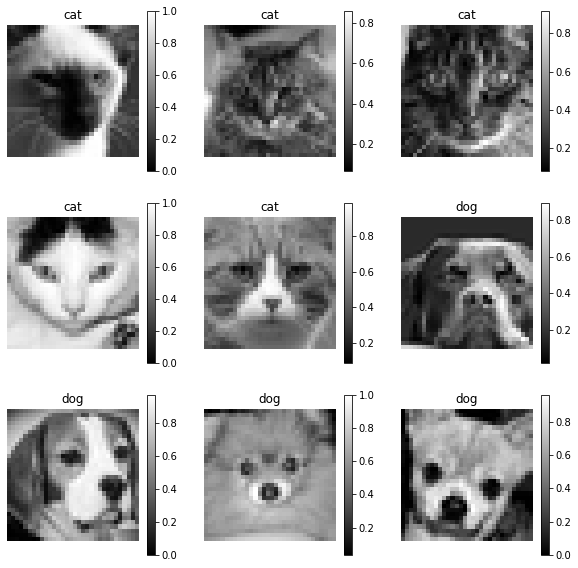

In [21]:
# Plot images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for count, i in enumerate(range(0,110, 13)):
    ax = plt.subplot(3, 3, count + 1)
    plt.imshow(train_images[i],cmap='gray')
    plt.colorbar()
    plt.title(class_names[y[i]])
    plt.axis("off")

What is the new minimum and maximum value of X?

The maximum value is now 1 and the minimum value is zero.

### c) Reshaping the Data (5 points)

Please reshpe training images to be 1024-dim (from $32 \times 32$). 

Hint: look into numpy.reshape().


In [22]:
print(f'Before reshape, train_images shape: {train_images.shape}')

train_images_r = np.reshape(train_images, (110, -1))

print(f'Before reshape, train_images shape: {train_images_r.shape}')


Before reshape, train_images shape: (110, 32, 32)
Before reshape, train_images shape: (110, 1024)


### d) Building a Simple Neural Network (15 points)
In the cell below, build a fully-connected feed-forward neural network with the following layers:
* **input layer** of shape 1024
* **hidden layer** with 25 neurons, and relu activation
* **output layer** with 1 neuron, and sigmoid activation

In [23]:
from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import Callback

# Build neural network
def build_model1(): 
  model = Sequential() 
  model.add(Dense(units = 25, input_dim=1024, activation='relu'))
  model.add(Dense(units = 1, activation='sigmoid')) 
  return model

model = build_model1()

In [24]:
# Show a summary of your model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                25625     
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 25,651
Trainable params: 25,651
Non-trainable params: 0
_________________________________________________________________


Declare the optimizer using Stochastic Gradient Descient with learning rate of 0.001, weight decay of 1e-6 and momentum of 0.009. Compile your model using the 'binary_crossentropy' loss function and 'accuracy' as the metrics.

In [25]:
# Declare optimizer
optimizer = SGD(learning_rate=0.001, decay=1e-6, momentum=0.009)

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

Now we will train our model to learn pet faces using train_images and the 'y' labels. Our dataset is small so we will use 10% of the data as test set data. Train your model using the following parameters:

Fit your model using the train_images, 'y' labels, a batchsize of 10, and validation split of 0.1. Train for 500 epochs.

.fit documentation: https://www.tensorflow.org/api_docs/python/tf/keras/Model

In [26]:
y = y.reshape(-1,1)

# Call fit on your model passing in the X, y data above, train for 500 epochs
hist =  model.fit(train_images_r,
                    y, 
                    epochs=500, 
                    batch_size=10, 
                    validation_split=0.1,
                    #callbacks=[img_callback]
                  )

Epoch 1/500
10/10 [==============================] - 2s 42ms/step - loss: 0.7074 - accuracy: 0.5051 - val_loss: 0.8774 - val_accuracy: 0.0909
Epoch 2/500
10/10 [==============================] - 0s 18ms/step - loss: 0.7010 - accuracy: 0.5253 - val_loss: 0.8632 - val_accuracy: 0.0909
Epoch 3/500
10/10 [==============================] - 0s 7ms/step - loss: 0.6948 - accuracy: 0.5556 - val_loss: 0.8527 - val_accuracy: 0.0909
Epoch 4/500
10/10 [==============================] - 0s 15ms/step - loss: 0.6900 - accuracy: 0.5556 - val_loss: 0.8425 - val_accuracy: 0.0909
Epoch 5/500
10/10 [==============================] - 0s 13ms/step - loss: 0.6834 - accuracy: 0.5657 - val_loss: 0.8325 - val_accuracy: 0.0909
Epoch 6/500
10/10 [==============================] - 0s 8ms/step - loss: 0.6790 - accuracy: 0.5758 - val_loss: 0.8201 - val_accuracy: 0.0909
Epoch 7/500
10/10 [==============================] - 0s 9ms/step - loss: 0.6723 - accuracy: 0.5960 - val_loss: 0.8139 - val_accuracy: 0.0909
Epoch 8/5

In [27]:
def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
def plot_accuracies(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

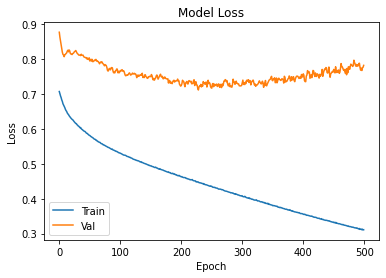

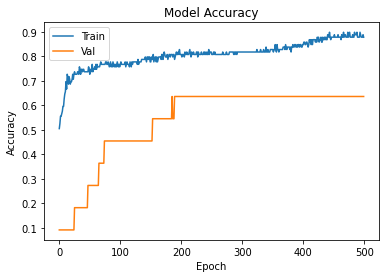

In [28]:
# plot your losses and accuracies
plot_losses(hist)
plot_accuracies(hist)

For the input size, this one hidden layer neural network is probably too small. However, we can see that the model attempts to minimize the overall loss. Summarize your observations on the model's learning curves, model's overall classification accuracy on the validation set, and the least amount of loss on validation set?

The model is doing quite a good job minimizing loss of the training data as it progresses, however, validation loss decreases far less quickly and actually begins to increase again after around 400 epochs, indicating overfitting beginning to happen. A loss of 0.65 on validation data seems to be the best achieved.

In terms of accuracy a similar result is visible, with considerable albeit diminishing improvement for both models up to around 400 epochs. Past that point, the training accuracy continues to improve while the validation accuracy stays at a best score of 0.8.

### e) Building a Second Neural Network (15 points)
Next, you will build a neural network with one hidden layer that is wider than the previous model's hidden layer. In the cell below, build a neural network with the following layers:
* **input layer** of shape 1024
* **hidden layer** with 100 neurons, and relu activation
* **output layer** with 1 neuron, and sigmoid activation

In [29]:
# Build neural network
def build_model2(): 
  model = Sequential() 
  model.add(Dense(units = 100, input_dim=1024, activation='relu'))
  model.add(Dense(units = 1, activation='sigmoid')) 
  return model

model = build_model2()

In [30]:
# Show a summary of your model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               102500    
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 102,601
Trainable params: 102,601
Non-trainable params: 0
_________________________________________________________________


Again, declare the optimizer using Stochastic Gradient Descient with learning rate of 0.001, weight decay of 1e-6 and momentum of 0.009. Compile your model using 'binary_crossentropy' loss function and 'accuracy' as the metrics.

In [31]:
# Declare optimizer
optimizer = SGD(learning_rate=0.001, decay=1e-6, momentum=0.009)

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In this sell fit your model using the train images, y labels, a batchsize of 10, and validation split of 0.1. Train for 500 epochs.

In [32]:
y = y.reshape(-1,1)

# Call fit on your model passing in the X, y data above, train for 500 epochs
hist =  model.fit(train_images_r,
                    y, 
                    epochs=500, 
                    batch_size=10, 
                    validation_split=0.1,
                    #callbacks=[img_callback]
                  )

Epoch 1/500
10/10 [==============================] - 1s 21ms/step - loss: 0.7270 - accuracy: 0.4747 - val_loss: 0.5607 - val_accuracy: 0.9091
Epoch 2/500
10/10 [==============================] - 0s 8ms/step - loss: 0.6824 - accuracy: 0.5051 - val_loss: 0.6383 - val_accuracy: 0.8182
Epoch 3/500
10/10 [==============================] - 0s 5ms/step - loss: 0.6624 - accuracy: 0.6061 - val_loss: 0.6833 - val_accuracy: 0.6364
Epoch 4/500
10/10 [==============================] - 0s 6ms/step - loss: 0.6499 - accuracy: 0.6465 - val_loss: 0.7171 - val_accuracy: 0.3636
Epoch 5/500
10/10 [==============================] - 0s 7ms/step - loss: 0.6425 - accuracy: 0.6465 - val_loss: 0.7302 - val_accuracy: 0.2727
Epoch 6/500
10/10 [==============================] - 0s 6ms/step - loss: 0.6357 - accuracy: 0.6970 - val_loss: 0.7504 - val_accuracy: 0.2727
Epoch 7/500
10/10 [==============================] - 0s 5ms/step - loss: 0.6288 - accuracy: 0.6768 - val_loss: 0.7514 - val_accuracy: 0.2727
Epoch 8/500


In [33]:
def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
def plot_accuracies(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

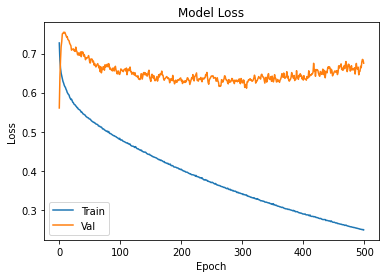

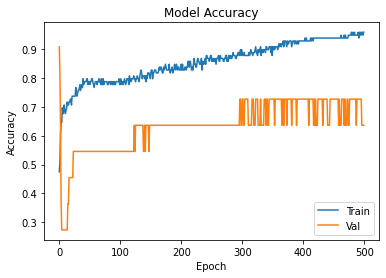

In [34]:
# Plot your losses and accuracies
plot_losses(hist)
plot_accuracies(hist)

Next, summarize this models results. Consider the following questions when answering. Remember that this model has a higher learning capacity than the previous model. 

1) How did this model compare to previous model? 

2) Did it outperform the previous models? 

3) What was your model's overall classification accuracy on the validation set and the least amount of loss on validation set? 

1) The most apparent difference between this and the previous model is the incrased learning rate. Validation loss reaches its minimum after only 200 or so epochs and validation accuracy reaches its maximum at the same point. Other than that, this model retained the same accuracies and loss rates and portrayed very similar curves during the learning phase.

2) This model really only outperformed the first in terms of learning rate, more quickly reaching its best loss and accuracies for the validation data. However, accuracy and loss were no more successful than the previous model and were in fact less stable, with accuracy quickly dropping off of the maximum value to a lower value closer to 0.6 as overfitting began to occur.

3) Best achieved accuracy for the validation set was 0.8 while best achieved loss for validation was around 0.70.

### f) Building a Third Neural Network (15 points)
Lastly, you will build a fully-connected neural network with two hidden layers. In the cell below, build a neural network with the following layers:
* **input layer** of shape 1024
* **hidden layer** with 100 neurons, and relu activation
* **hidden layer** with 25 neurons, and relu activation
* **output layer** with 1 neuron, and sigmoid activation

In [35]:
from tensorflow.keras.layers import Input, Dense # only use these layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import * # you can use any optimizer

# Build neural network
def build_model2(): 
  model = Sequential() 
  model.add(Dense(units = 25, input_dim=1024, activation='relu'))
  model.add(Dense(units = 100, activation='relu'))
  model.add(Dense(units = 25, activation='relu'))
  model.add(Dense(units = 1, activation='sigmoid')) 
  return model

model = build_model2()

In [36]:
# Show a summary of your model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 25)                25625     
                                                                 
 dense_5 (Dense)             (None, 100)               2600      
                                                                 
 dense_6 (Dense)             (None, 25)                2525      
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                                                                 
Total params: 30,776
Trainable params: 30,776
Non-trainable params: 0
_________________________________________________________________


Since this model is bigger than the previous models, we will use a more powerful optimizer. Declare the optimizer as Adam with learning rate of 0.001. Compile your model using 'binary_crossentropy' loss function and 'accuracy' as the metrics.

In [37]:
# Declare optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In this sell fit your model using the train images, y labels, a batchsize of 10, and validation split of 0.1. Train for 500 epochs.

In [38]:
y = y.reshape(-1,1)

# Call fit on your model passing in the X, y data above, train for 500 epochs
hist =  model.fit(train_images_r,
                    y, 
                    epochs=500, 
                    batch_size=10, 
                    validation_split=0.1,
                    #callbacks=[img_callback]
                  )

Epoch 1/500
10/10 [==============================] - 1s 35ms/step - loss: 0.6864 - accuracy: 0.5253 - val_loss: 0.7972 - val_accuracy: 0.0909
Epoch 2/500
10/10 [==============================] - 0s 7ms/step - loss: 0.6098 - accuracy: 0.6465 - val_loss: 0.5244 - val_accuracy: 0.9091
Epoch 3/500
10/10 [==============================] - 0s 7ms/step - loss: 0.5712 - accuracy: 0.7273 - val_loss: 0.5341 - val_accuracy: 0.8182
Epoch 4/500
10/10 [==============================] - 0s 6ms/step - loss: 0.5386 - accuracy: 0.7071 - val_loss: 1.5171 - val_accuracy: 0.0000e+00
Epoch 5/500
10/10 [==============================] - 0s 5ms/step - loss: 0.5937 - accuracy: 0.6869 - val_loss: 0.4542 - val_accuracy: 0.9091
Epoch 6/500
10/10 [==============================] - 0s 6ms/step - loss: 0.4958 - accuracy: 0.7778 - val_loss: 0.5188 - val_accuracy: 0.8182
Epoch 7/500
10/10 [==============================] - 0s 11ms/step - loss: 0.4635 - accuracy: 0.7576 - val_loss: 0.7248 - val_accuracy: 0.7273
Epoch 8

In [39]:
def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
def plot_accuracies(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

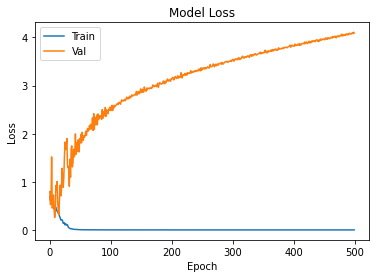

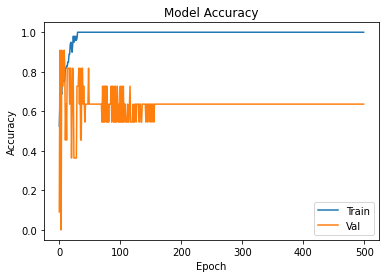

In [40]:
# plot your losses and accuracies
plot_losses(hist)
plot_accuracies(hist)

Summarize this model's results. Consider the following when answering:

1) How did this model compare to previous models? 

2) Did it outperform the previous models? 

3) What was your model's overall classification accuracy on the validation set and the least amount of loss on validation set? 

4) Adam is a powerful optimizer, and may quickly converge to an a minima. Did this happen with this model?

1) This model shows by far the fastest training rate of all, with a very different set of curves as more empochs were computed.

2) This model doesn't outperform the previous ones in terms of accuracy, which tops out in a stable way around 0.8, no better than the first model's. In terms of loss, this model also has extremely large validation loss values very quickly, values are already at 4 by the time model accuracy begins to plateu.

3) This model has a validation loss of around 0.5 during the first 30 epochs of training before it begins to increase significantly. Meanwhile best achieved accuracy is around 0.65.

4) In terms of loss this definetly occured, minimas were achieved around 30 epochs before the loss began to drastically increase for the validation set and stop decrasing for training data. Similarly, it took only around 70 epochs for both training and validation accuracies to reach their maximum, far lower than with the SGD optimizers.

NOTE: the values I am reporting change somewhat during different calls to make a neural network, therefore the values are estimates and comparisons are relative. For example, sometimes best accuracy rates are 0.8 while sometimes they are only 0.65 for the same model across different runs.